In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().system('tree -L 2')

.
├── README.md
├── Tephra2
│   ├── README.md
│   ├── README.usage
│   ├── common_src
│   ├── find_best_wind.pl
│   ├── forward_src
│   ├── include
│   ├── inputs
│   ├── inversion_src
│   ├── libcygwin64
│   ├── libmac
│   ├── license.md
│   ├── makefile
│   ├── plotting_scripts
│   ├── run-inversion
│   ├── tephra2-inversion_2020
│   └── tephra2_2020
├── config
│   ├── __pycache__
│   └── default_config.py
├── data
│   ├── input
│   └── output
├── example.ipynb
├── node_
├── plume2.dat
├── requirements.txt
├── scripts
│   ├── __pycache__
│   ├── core
│   ├── data_handling
│   ├── tephra_inversion.py
│   └── visualization
└── tephra_inversion.log

20 directories, 16 files


In [2]:
# ─────────────────────────────────────────────────────────────
# Cell 1 – imports & basic setup
# ─────────────────────────────────────────────────────────────
import copy, sys, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

from scripts.tephra_inversion import TephraInversion
from scripts.data_handling.build_inputs import build_all
from scripts.data_handling.observation_data import ObservationHandler
from scripts.visualization.diagnostic_plots import DiagnosticPlotter

In [3]:
# ─────────────────────────────────────────────────────────────
# Cell 2 – generate the two Tephra2 input files
# ─────────────────────────────────────────────────────────────
vent_lat, vent_lon, vent_elev = 31.9, 130.9, 1000


conf_path, esp_path, wind_path = build_all(
    vent_lat  = vent_lat,
    vent_lon  = vent_lon,
    vent_elev = vent_elev,
)
# now data/input/{observations.csv,sites.csv,wind.txt} are ready

ImportError: Victor package required for DEM downloads. Install with 'pip install victor-api'.

In [4]:
# ─────────────────────────────────────────────────────────────
# Cell 3 – wrap observations + sites into one DataFrame
# ─────────────────────────────────────────────────────────────
obs_handler = ObservationHandler("data/input")
obs_vec, sites = obs_handler.load_observations()

# build the same DataFrame
obs_df = pd.DataFrame({
    "easting":     sites[:, 0],
    "northing":    sites[:, 1],
    "elevation":   sites[:, 2],
    "observation": obs_vec,
})

obs_df

2025-05-06 01:15:36,048 - scripts.data_handling.observation_data - INFO - Using whitespace separator for sites.csv
2025-05-06 01:15:36,049 - scripts.data_handling.observation_data - INFO - Loaded 63 observations


,easting,northing,elevation,observation
0,691998.0,3520374.0,1000.0,10.00
1,688621.0,3522661.0,1000.0,18.00
2,685128.0,3524972.0,1000.0,15.00
3,682997.0,3529018.0,1000.0,51.00
4,682918.0,3528234.0,1000.0,55.33
...,...,...,...,...
58,682730.0,3528208.0,1000.0,50.00
59,685508.0,3529620.0,1000.0,20.00
60,685518.0,3529780.0,1000.0,18.00
61,697972.0,3527237.0,1000.0,1.00


In [5]:
# ─────────────────────────────────────────────────────────────
# Cell 4 – run the MCMC inversion
# ─────────────────────────────────────────────────────────────
inv = TephraInversion(
    vent_lat, vent_lon, vent_elev,
    config={"mcmc": {
        "n_iterations": 1000,
        "n_burnin":     0,
        # you can toggle load_observations/load_wind here if you like
    }}
)

results = inv.run_inversion()

burnin = inv.config["mcmc"]["n_burnin"]
# Convert results chain → sample arrays
samples = {}
for param in results["chain"].columns:
    samples[param] = results["chain"][param].values

2025-05-06 01:15:36,058 - scripts.data_handling.observation_data - INFO - Using whitespace separator for sites.csv
2025-05-06 01:15:36,059 - scripts.data_handling.observation_data - INFO - Loaded 63 observations
2025-05-06 01:15:36,242 - rasterio._env - INFO - GDAL signalled an error: err_no=4, msg='tephra2.tiff: No such file or directory'
[WARNING] Could not open 'tephra2.tiff' for background map.
2025-05-06 01:15:36,371 - scripts.data_handling.wind_data - INFO - Loaded wind profile from data/input/wind.txt
tephra2.conf written → data/input/tephra2.conf
esp_input.csv written → data/input/esp_input.csv
2025-05-06 01:15:36,645 - scripts.data_handling.build_inputs - INFO - All inputs & plots written to /Users/jimyhc/Desktop/Spring 2025/DSI/root/data/input
2025-05-06 01:15:36,646 - scripts.data_handling.observation_data - INFO - Using whitespace separator for sites.csv
2025-05-06 01:15:36,647 - scripts.data_handling.observation_data - INFO - Loaded 63 observations
2025-05-06 01:15:36,647 

MCMC: 100%|██████████| 1000/1000 [00:19<00:00, 52.28it/s, acc=0.418, lnM=23.6, plume=8.22e+3]

2025-05-06 01:15:55,822 - scripts.tephra_inversion - INFO - MCMC finished: 1000 iters, accept=0.42


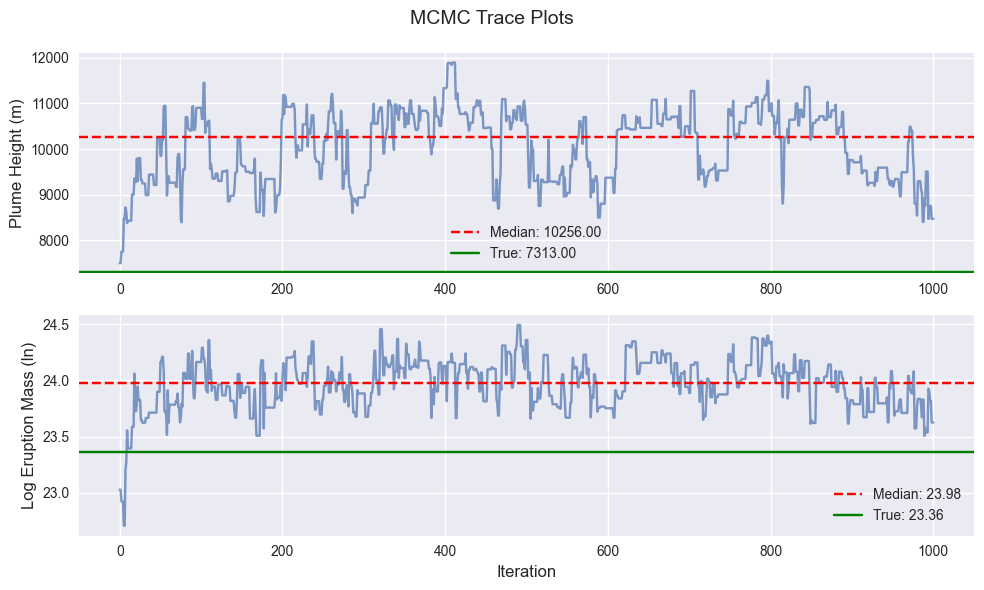


Posterior Summary Statistics:
       Parameter          Mean        Median      CI_2.5%      CI_97.5%
0  column_height  10051.248205  10256.003276  8543.777667  11296.243258
1          log_m     23.966509     23.975441    23.573680     24.356616


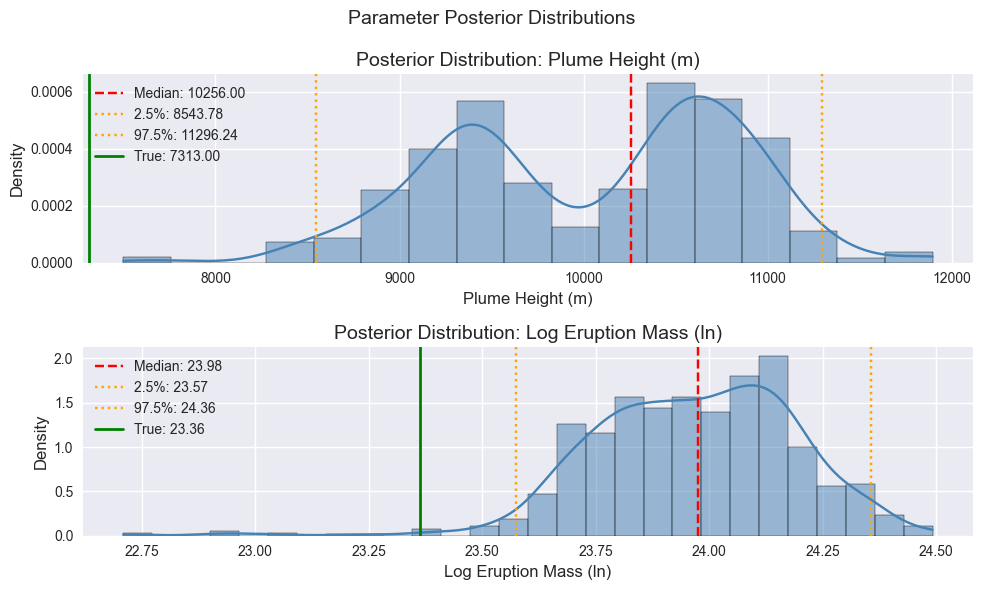

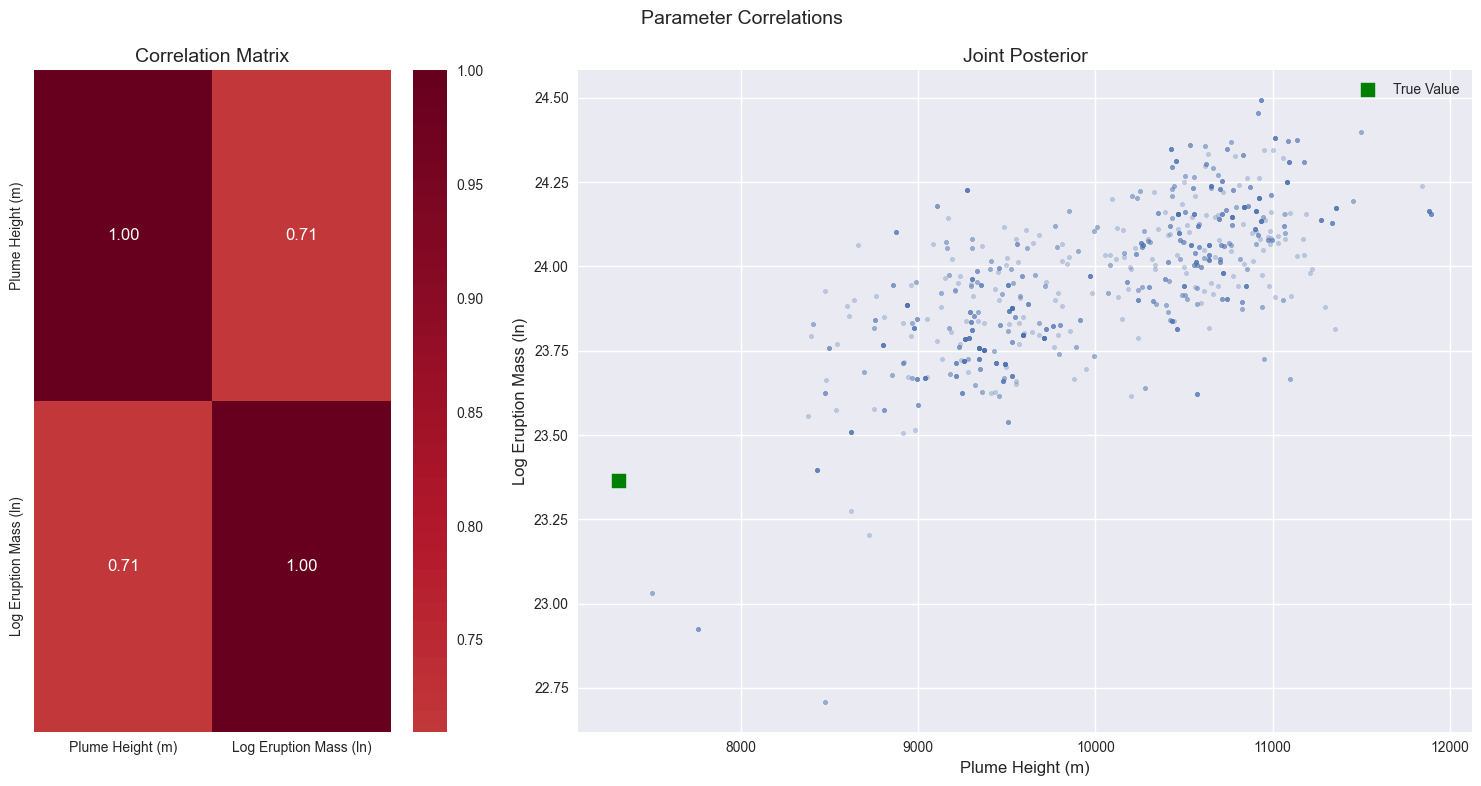

Summary saved to data/output/plots/posterior_summary.csv
       Parameter            Pretty Label          Mean        Median  \
0  column_height        Plume Height (m)  10051.248205  10256.003276   
1          log_m  Log Eruption Mass (ln)     23.966509     23.975441   

      Std Dev      CI_2.5%      CI_97.5%   True Value  
0  788.316497  8543.777667  11296.243258  7313.000000  
1    0.225334    23.573680     24.356616    23.362323  

Best Parameter Estimates vs. True Values:


In [ ]:
# ─────────────────────────────────────────────────────────────
# Cell 5 – diagnostic plots with DiagnosticPlotter
# ─────────────────────────────────────────────────────────────
from scripts.visualization.diagnostic_plots import DiagnosticPlotter

# 1) Instantiate the plotter with only the output directory
plotter = DiagnosticPlotter(output_dir="data/output/plots")

# 2) Build the samples dict directly from results["chain"]
samples = { col: results["chain"][col].values for col in results["chain"].columns }

# 3) Now call each method with (samples, burnin) as first two arguments:

# Trace plots
plotter.plot_trace(
    samples, 
    burnin,
    title     = "MCMC Trace Plots",
    save_path = "data/output/plots/mcmc_trace.png"
)

# Posterior distributions
plotter.plot_parameter_distributions(
    samples, 
    burnin,
    title     = "Parameter Posterior Distributions",
    save_path = "data/output/plots/parameter_distributions.png"
)

# Correlations / joint-posteriors
plotter.plot_parameter_correlations(
    samples, 
    burnin,
    title     = "Parameter Correlations",
    save_path = "data/output/plots/parameter_correlations.png"
)

# Summarize to CSV
summary_df = plotter.summarize_posterior(
    samples, 
    burnin,
    save_path = "data/output/plots/posterior_summary.csv"
)
print(summary_df)

# Best vs true
print("\nBest Parameter Estimates vs. True Values:")
for param, best in results["best_params"].items():
    true = plotter.true_values.get(param)
    if true is not None:
        label = plotter._get_pretty_label(param)
        print(f"{label}: Best = {best:.4f}, True = {true:.4f}")